In [ ]:
!pip install gymnasium
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 865.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# FINAL PHASE

This is Phase 4. In this phase, we'll build 10 tried and tested signal functions. Our PPO model will generate weights based on each indicator. Our model will generate both long and short signals, and will allocate weights of our entire portfolio into various positions prompted by the indicators. We will be using the TSLA stock, and train our model on 2010-2023, then test it on 2024.

In [ ]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from itertools import product
from datetime import timedelta

# ══════════════════════════════════════════════════════════════════════════════
# 1) DATA LOADING & CLEANING
# ══════════════════════════════════════════════════════════════════════════════
def parse_volume(x):
    s = str(x).replace(',','').strip().upper()
    if s.endswith('M'): return float(s[:-1]) * 1e6
    if s.endswith('K'): return float(s[:-1]) * 1e3
    try: return float(s)
    except: return np.nan

def load_tsla(path):
    df = pd.read_csv(path, parse_dates=['Date'])
    df.rename(columns={'Price':'Close','Vol.':'Volume','Change %':'ChangePct'}, inplace=True)
    df = df.sort_values('Date').reset_index(drop=True)
    df['Volume'] = df['Volume'].apply(parse_volume)
    df['ChangePct'] = (
        df['ChangePct'].astype(str)
            .str.rstrip('%')
            .replace('', np.nan)
            .astype(float)
            .div(100)
    )
    df.set_index('Date', inplace=True)
    return df
# ══════════════════════════════════════════════════════════════════════════════
# 2) TEN STRATEGY SIGNAL FUNCTIONS
# ══════════════════════════════════════════════════════════════════════════════
def strat_mom(df,n=10):
    return df.Close.pct_change(n).shift(1).fillna(0)
def strat_meanrev(df,n=5):
    r  = df.Close.pct_change().fillna(0)
    mu = r.rolling(n).mean()
    sd = r.rolling(n).std()+1e-8
    return (-(r-mu)/sd).shift(1).fillna(0)
def strat_ma_crossover(df,f=5,s=20):
    fast = df.Close.rolling(f).mean()
    slow = df.Close.rolling(s).mean()
    return ((fast-slow)/df.Close).shift(1).fillna(0)
def strat_vol_breakout(df,n=20):
    rng = df.Close.rolling(n).std()+1e-8
    low = df.Low.rolling(n).min()
    return ((df.Close - low)/rng).shift(1).fillna(0)
def strat_vol_trend(df,n=10):
    return df.Volume.pct_change(n).shift(1).fillna(0)
def strat_rsi(df,n=14):
    d    = df.Close.diff()
    up   = d.clip(lower=0)
    down = -d.clip(upper=0)
    rs   = up.rolling(n).mean()/(down.rolling(n).mean()+1e-8)
    rsi  = 100 - 100/(1+rs)
    return (rsi/100).shift(1).fillna(0)
def strat_macd(df,fast=12,slow=26,signal=9):
    ef   = df.Close.ewm(span=fast,adjust=False).mean()
    es   = df.Close.ewm(span=slow,adjust=False).mean()
    macd = ef - es
    sig  = macd.ewm(span=signal,adjust=False).mean()
    hist = macd - sig
    den  = hist.abs().rolling(signal).mean()+1e-8
    return (hist/den).shift(1).fillna(0)
def strat_atr_mom(df,n=14):
    h,l,c = df.High, df.Low, df.Close
    tr     = pd.concat([h-l, (h-c.shift()).abs(), (l-c.shift()).abs()], axis=1).max(axis=1)
    atr    = tr.rolling(n).mean()
    mom    = (atr.shift(1)-atr.shift(n+1))/(atr.shift(n+1)+1e-8)
    return mom.fillna(0)
def strat_bollinger_pct(df,n=20,k=2):
    mid = df.Close.rolling(n).mean()
    sd  = df.Close.rolling(n).std()+1e-8
    return ((df.Close-mid)/(k*sd)).shift(1).fillna(0)
def strat_obv_mom(df,n=10):
    obv = (np.sign(df.Close.diff()) * df.Volume).fillna(0).cumsum()
    d   = obv.diff().fillna(0)
    return ((d - d.rolling(n).mean())/(d.rolling(n).std()+1e-8)).shift(1).fillna(0)

strategy_funcs = [
    strat_mom, strat_meanrev, strat_ma_crossover, strat_vol_breakout,
    strat_vol_trend, strat_rsi, strat_macd, strat_atr_mom,
    strat_bollinger_pct, strat_obv_mom
]
K = len(strategy_funcs)

# RL Env
Here we define our RL environment. You'll notice some differences between the previous phases. The actions are continuous vectors, with one weight per strategy signal. We did try some "Pick One" environments to just choose the most optimal strategy, however our final env used a continuous weighting system, that way our agent can enter multiple different positions aiming to maximize reward. The computed indicators are the inputs for our agent. Rather than raw prices or returns, these indicators summarize market moves and trends, allowing for meaningful learning. The final signal is the dot product of weights (from agent) and signals (computed). The reward function is largely based on PnL and portfolio returns, however we also made sure to have a turnover penalty to simulate transaction costs, volatility penalty, AND drawdown penalties. This allows our agent to be *risk aware* and conservative, while mainly chasing winning trades. Additionally, we have a final step bonus, which is a small positive bonus at the end of the process which is based on ending balance. This gives the agent an extra incentive to maximize *terminal* wealth, and shaped the ultimate goal of portfolio gain.

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 3) CONTINUOUS-WEIGHT RISK-AWARE ENVIRONMENT
# ══════════════════════════════════════════════════════════════════════════════
class AllocEnv(gym.Env):
    def __init__(self, df, init_cap=1e5,
                 turnover_penalty=1e-6,
                 lambda_vol=1e-4, mu_dd=1e-4,
                 final_bonus=1e-4, vol_window=10):
        super().__init__()
        self.df       = df.sort_index()
        self.init_cap = float(init_cap)
        self.pen      = float(turnover_penalty)
        self.lam_vol  = float(lambda_vol)
        self.mu_dd    = float(mu_dd)
        self.final_b  = float(final_bonus)
        self.V        = int(vol_window)

        # precompute
        self.rets    = self.df.Close.pct_change().fillna(0).values
        S = np.vstack([f(self.df).values for f in strategy_funcs]).T
        self.signals = np.nan_to_num(S.astype(np.float32), nan=0.0)

        self.T, self.K = self.signals.shape

        # spaces
        self.action_space = spaces.Box(-1,1,shape=(self.K,),dtype=np.float32)
        self.observation_space = spaces.Box(-np.inf,np.inf,(self.K,),dtype=np.float32)

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.t       = 1
        self.balance = self.init_cap
        self.last_w  = np.zeros(self.K, np.float32)
        self.equity  = [self.init_cap]
        self.pf_rets = []
        return self.signals[0], {}

    def step(self, action):
        # 1) normalize continuous weights → sum|w|=1
        w = np.clip(action, -1, 1)
        s = np.sum(np.abs(w))
        if s>0: w = w/s

        # 2) compute signal & pnl
        sig = float(w @ self.signals[self.t])
        r   = float(self.rets[self.t])
        pnl = self.balance * sig * r
        self.balance += pnl
        self.equity.append(self.balance)
        self.pf_rets.append(sig * r)

        # 3) turnover penalty
        tc = self.pen * np.sum(np.abs(w - self.last_w)) * self.balance

        # 4) volatility & drawdown penalty
        vol = np.std(self.pf_rets[-self.V:]) if len(self.pf_rets)>=self.V else 0.0
        running_max = max(self.equity)
        dd  = (running_max - self.balance) / running_max
        risk_pen = self.lam_vol * vol * self.balance + self.mu_dd * dd * self.balance

        # 5) reward, with terminal bonus
        reward = pnl - tc - risk_pen
        done = self.t >= self.T-1
        if done:
            reward += self.final_b * self.balance

        # 6) book‐keep & obs
        self.last_w = w.copy()
        self.t     += 1
        obs = self.signals[self.t-1] if not done else np.zeros(self.K, np.float32)
        return obs, reward, done, False, {}

    def render(self, mode='human'):
        print(f"Step {self.t} | Balance {self.balance:.2f}")

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 4) TRAIN/TEST SPLIT
# ══════════════════════════════════════════════════════════════════════════════
df = load_tsla('/content/Tesla Stock Price History2010-2024.csv') # Sourced from https://www.investing.com/equities/tesla-motors-historical-data
df_train = df.loc['2010-01-01':'2023-12-31']
df_test  = df.loc['2024-01-01':'2024-12-31']

# WARNING !!!!
This next chunk WILL take around 2.5-3 hours to run. Yes I did have the patience to wait, I could have maybe parallelized it, but I also had Mother's Day dinner so I just let it run at home.

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 5) GRID SEARCH (train+eval on train→ pick best)
# ══════════════════════════════════════════════════════════════════════════════
best = {'bal': -np.inf}
search_space = {
    'lr':           [3e-4, 1e-4, 3e-5],
    'n_steps':     [1024,2048],
    'batch_size':  [32,64],
    'turn_pen':    [1e-6,1e-5],
    'lambda_vol':  [1e-4,5e-4],
    'mu_dd':       [1e-4,5e-4]
}

for lr,n_steps,batch,turn,lam,mu in product(
        search_space['lr'],
        search_space['n_steps'],
        search_space['batch_size'],
        search_space['turn_pen'],
        search_space['lambda_vol'],
        search_space['mu_dd']
    ):
    env0 = AllocEnv(df_train,
                    turnover_penalty=turn,
                    lambda_vol=lam, mu_dd=mu,
                    final_bonus=1e-4, vol_window=10)
    model0 = PPO('MlpPolicy', env0,
                 learning_rate=lr,
                 n_steps=n_steps,
                 batch_size=batch,
                 verbose=0)
    model0.learn(total_timesteps=50_000)
    # quick train‐only test:
    obs,_ = env0.reset()
    done=False
    while not done:
        action,_ = model0.predict(obs,deterministic=True)
        obs,_,done,_,_ = env0.step(action)
    bal = env0.balance
    if bal>best['bal']:
        best = dict(bal=bal, lr=lr, n_steps=n_steps,
                    batch_size=batch,
                    turn=turn, lam=lam, mu=mu)

print("🏆 Best (train) →", best)

🏆 Best (train) → {'bal': 34426877.4800535, 'lr': 0.0001, 'n_steps': 2048, 'batch_size': 64, 'turn': 1e-05, 'lam': 0.0001, 'mu': 0.0001}


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 6) RE-TRAIN BEST ON FULL TRAIN
# ══════════════════════════════════════════════════════════════════════════════
env_train = AllocEnv(df_train,
                     turnover_penalty=best['turn'],
                     lambda_vol=best['lam'],
                     mu_dd=best['mu'],
                     final_bonus=1e-4, vol_window=10)
model = PPO('MlpPolicy', env_train,
            learning_rate=best['lr'],
            n_steps=best['n_steps'],
            batch_size=best['batch_size'],
            verbose=1)
model.learn(total_timesteps=200_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 911  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.4e+03     |
|    ep_rew_mean          | -9.05e+04   |
| time/                   |             |
|    fps                  | 774         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005821565 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 1.17e-05    |
|    learning_rate        | 0.0001      |
|    loss               

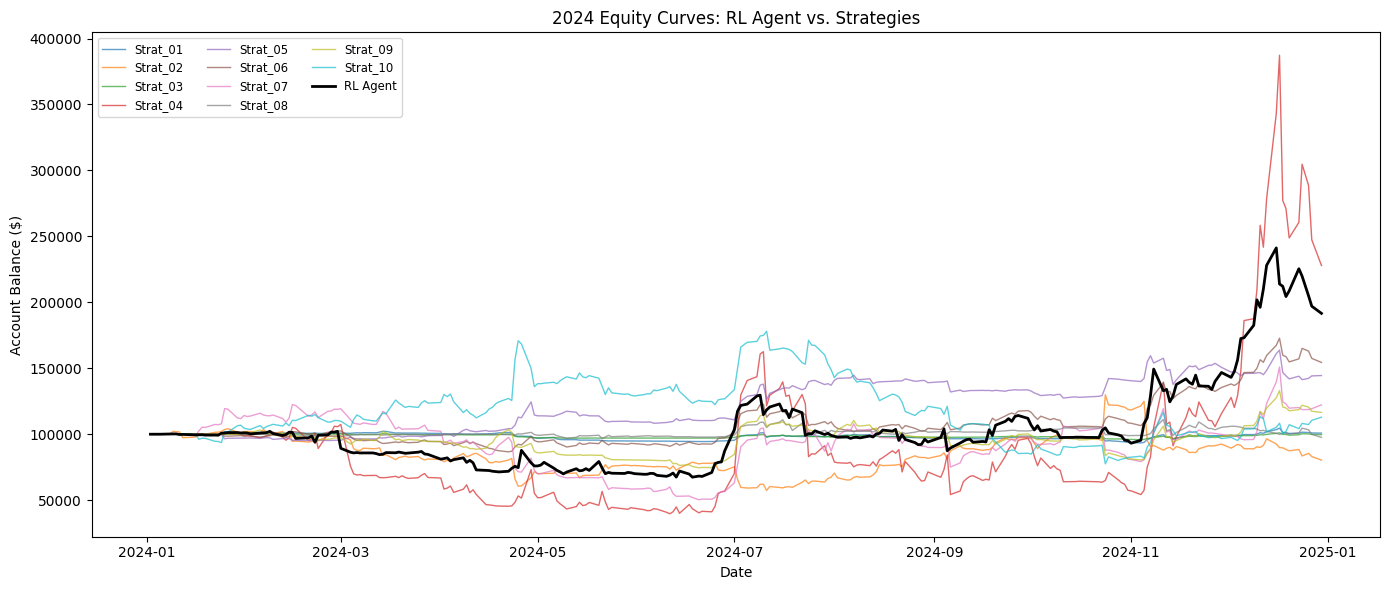

   Model  Final Balance  Ann. Sharpe  Max Drawdown
Strat_04    227936.8767       1.3146        0.6663
RL Agent    191625.4844       1.2747        0.3400
Strat_06    154425.7679       1.4121        0.1710
Strat_05    144484.0033       1.2709        0.1369
Strat_07    122214.1294       0.6622        0.5893
Strat_09    116539.0071       0.5720        0.2964
Strat_10    112899.2832       0.5039        0.5646
Strat_01    100830.3522       0.1354        0.0863
Strat_03     99665.8880      -0.0430        0.0473
Strat_08     97613.4885       0.0019        0.1220
Strat_02     80386.8524      -0.0084        0.4492


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 7) EVALUATION ON TEST: RL + Baselines
# ══════════════════════════════════════════════════════════════════════════════
# simulate RL
env_test = AllocEnv(df_test,
                    turnover_penalty=best['turn'],
                    lambda_vol=best['lam'],
                    mu_dd=best['mu'],
                    final_bonus=1e-4, vol_window=10)
obs,_ = env_test.reset()
rl_eq = [env_test.balance]
rl_weights = []
done=False
while not done:
    action,_ = model.predict(obs, deterministic=True)
    obs,_,done,_,_ = env_test.step(action)
    rl_eq.append(env_test.balance)
    # record last_w
    rl_weights.append(env_test.last_w.copy())

# simulate each pure‐strategy
rets = df_test.Close.pct_change().fillna(0).values
def simulate(signals, returns, init=1e5):
    bal=init
    out=[bal]
    for sig,r in zip(signals,returns):
        bal += bal*sig*r
        out.append(bal)
    return np.array(out)

strat_eqs = {}
for i,f in enumerate(strategy_funcs, start=1):
    s = f(df_test).fillna(0).values
    strat_eqs[f"Strat_{i:02d}"] = simulate(s, rets)

# ══════════════════════════════════════════════════════════════════════════════
# 8) METRIC FUNCTIONS
# ══════════════════════════════════════════════════════════════════════════════
def sharpe(equity, periods_per_year=252):
    # daily returns of equity
    r = np.diff(equity)/equity[:-1]
    return np.mean(r)/ (np.std(r)+1e-8) * np.sqrt(periods_per_year)

def max_drawdown(equity):
    eq = np.array(equity)
    roll_max = np.maximum.accumulate(eq)
    dd = (roll_max - eq)/roll_max
    return float(dd.max())

# ══ 9) PLOT ALL EQUITY CURVES (fixed alignment) ═════════════════════════
# full dates
dates_full = df_test.index

# drop initial capital from RL and each strat
rl_curve_raw = np.array(rl_eq[1:])
strat_curves_raw = {name: eq[1:] for name, eq in strat_eqs.items()}

# find minimum length
lengths = [len(dates_full), len(rl_curve_raw)] + [len(c) for c in strat_curves_raw.values()]
min_len = min(lengths)

# truncate all to min_len
dates      = dates_full[:min_len]
rl_curve   = rl_curve_raw[:min_len]
strat_curves = {name: c[:min_len] for name, c in strat_curves_raw.items()}

# Sanity check: all series lengths must match
assert all(len(curve) == len(dates) for curve in strat_curves.values())
assert len(rl_curve) == len(dates)

# ─── PLOT EQUITY CURVES ───────────────────────────────────────────────────────
plt.figure(figsize=(14,6))
for name, curve in strat_curves.items():
    plt.plot(dates, curve, alpha=0.7, linewidth=1, label=name)
plt.plot(dates, rl_curve, 'k-', linewidth=2, label='RL Agent')
plt.legend(ncol=3, fontsize='small', loc='upper left')
plt.title("2024 Equity Curves: RL Agent vs. Strategies")
plt.xlabel("Date"); plt.ylabel("Account Balance ($)")
plt.tight_layout()
plt.show()

# ─── PERFORMANCE TABLE ────────────────────────────────────────────────────────
rows = []
rows.append({
    'Model': 'RL Agent',
    'Final Balance': float(rl_curve[-1]),
    'Ann. Sharpe': sharpe(rl_curve),
    'Max Drawdown': max_drawdown(rl_curve)
})
for name, curve in strat_curves.items():
    rows.append({
        'Model': name,
        'Final Balance': float(curve[-1]),
        'Ann. Sharpe': sharpe(curve),
        'Max Drawdown': max_drawdown(curve)
    })

perf_df = pd.DataFrame(rows).sort_values('Final Balance', ascending=False)
print(perf_df.to_string(index=False, float_format="%.4f"))


# WONDERFUL!!

Here we see equity curves of each individual strategy compared to our RL agent which weights each strategy. Our agent was the second best performer, just behind strategy 4, HOWEVER, our agent had a much lower drawdown than strategy 4. Additionally, it had a comparable Sharpe ratio to strategy 4, indicating that both had great risk adjusted returns. Our agent performed very well in 2024, and although it was beat by strategy 4 alone, it was less risky and more conservative, indicating that RL Agents may be a key to automating intelligent quantitative trades while averting risk and drawdown. Lets view how our Agent weighted strategies throughout 2024

            Strat_01  Strat_02  Strat_03  Strat_04  Strat_05  Strat_06  \
Date                                                                     
2024-01-03 -0.011513  0.102725  -0.18492  0.351154  0.023537   0.02571   
2024-01-04 -0.011513  0.102725  -0.18492  0.351154  0.023537   0.02571   
2024-01-05 -0.011513  0.102725  -0.18492  0.351154  0.023537   0.02571   
2024-01-08 -0.011513  0.102725  -0.18492  0.351154  0.023537   0.02571   
2024-01-09 -0.011513  0.102725  -0.18492  0.351154  0.023537   0.02571   

            Strat_07  Strat_08  Strat_09  Strat_10  
Date                                                
2024-01-03  0.020956  0.173672  -0.07294 -0.032873  
2024-01-04  0.020956  0.173672  -0.07294 -0.032873  
2024-01-05  0.020956  0.173672  -0.07294 -0.032873  
2024-01-08  0.020956  0.173672  -0.07294 -0.032873  
2024-01-09  0.020956  0.173672  -0.07294 -0.032873  


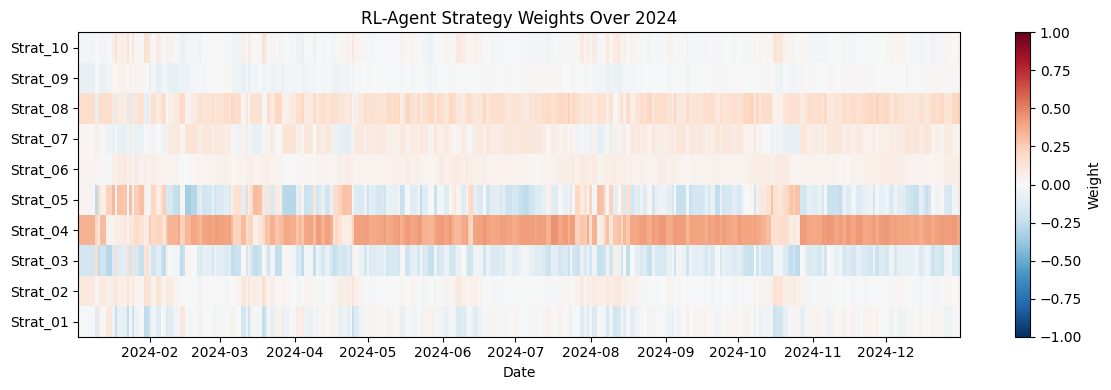

In [ ]:
import pandas as pd

K = len(strategy_funcs)

# align dates: weights[i] is the weight used on df_test.index[i+1]
dates = df_test.index[1:1+len(rl_weights)]

# make nice column names
cols = [f"Strat_{i:02d}" for i in range(1, K+1)]

# build DataFrame
weights_df = pd.DataFrame(rl_weights, index=dates, columns=cols)

# peek
print(weights_df.head())

# if you want a quick heatmap of how those weights evolve:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.pcolormesh(
    pd.to_datetime(weights_df.index),
    range(K),
    weights_df.T.values,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.yticks(range(K), cols)
plt.colorbar(label='Weight')
plt.title("RL-Agent Strategy Weights Over 2024")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


Okay so strategy 4 was definitely a large part of our portfolio allocation, however we can see that our agent switches strategies when necessary. Additionally, we can see that it utilized various strategies to generate short positions, all of which helped it to be a winner. Overall, while strategy 4 was the highest weighted, the periods where our Agent *beat* strategy 4 was thanks to the other strategies, and the dynamic weighting of our agent. This prototype serves to stimulate discussion of using RL agents to shape decisions in various market moods. Changing a few parameters allows us to generate a very risk averse agent, and the possibilities of reinforcement learning are ever expanding. Proximal Policy Optimization essentially allowed us to generate a risk-conscious and quantitatively inclined trader.

In [ ]:
df = load_tsla('/content/SPY ETF Stock Price History2010-2024.csv') # sourced from https://www.investing.com/etfs/spdr-s-p-500-historical-data
df_train = df.loc['2010-01-01':'2023-12-31']
df_test  = df.loc['2024-01-01':'2024-12-31']

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 5) GRID SEARCH (train+eval on train→ pick best)
# ══════════════════════════════════════════════════════════════════════════════
best = {'bal': -np.inf}
search_space = {
    'lr':           [3e-4, 1e-4, 3e-5],
    'n_steps':     [1024,2048],
    'batch_size':  [32,64],
    'turn_pen':    [1e-6,1e-5],
    'lambda_vol':  [1e-4,5e-4],
    'mu_dd':       [1e-4,5e-4]
}

for lr,n_steps,batch,turn,lam,mu in product(
        search_space['lr'],
        search_space['n_steps'],
        search_space['batch_size'],
        search_space['turn_pen'],
        search_space['lambda_vol'],
        search_space['mu_dd']
    ):
    env0 = AllocEnv(df_train,
                    turnover_penalty=turn,
                    lambda_vol=lam, mu_dd=mu,
                    final_bonus=1e-4, vol_window=10)
    model0 = PPO('MlpPolicy', env0,
                 learning_rate=lr,
                 n_steps=n_steps,
                 batch_size=batch,
                 verbose=0)
    model0.learn(total_timesteps=50_000)
    # quick train‐only test:
    obs,_ = env0.reset()
    done=False
    while not done:
        action,_ = model0.predict(obs,deterministic=True)
        obs,_,done,_,_ = env0.step(action)
    bal = env0.balance
    if bal>best['bal']:
        best = dict(bal=bal, lr=lr, n_steps=n_steps,
                    batch_size=batch,
                    turn=turn, lam=lam, mu=mu)

print("🏆 Best (train) →", best)

<ipython-input-3-b76a117aece3>:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.Volume.pct_change(n).shift(1).fillna(0)
<ipython-input-3-b76a117aece3>:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.Volume.pct_change(n).shift(1).fillna(0)
<ipython-input-3-b76a117aece3>:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.Volume.pct_change(n).shift(1).fillna(0)
<ipython-i

🏆 Best (train) → {'bal': 770754.3832392149, 'lr': 3e-05, 'n_steps': 2048, 'batch_size': 64, 'turn': 1e-06, 'lam': 0.0005, 'mu': 0.0001}


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 6) RE-TRAIN BEST ON FULL TRAIN
# ══════════════════════════════════════════════════════════════════════════════
env_train = AllocEnv(df_train,
                     turnover_penalty=best['turn'],
                     lambda_vol=best['lam'],
                     mu_dd=best['mu'],
                     final_bonus=1e-4, vol_window=10)
model = PPO('MlpPolicy', env_train,
            learning_rate=best['lr'],
            n_steps=best['n_steps'],
            batch_size=best['batch_size'],
            verbose=1)
model.learn(total_timesteps=200_000)

<ipython-input-3-b76a117aece3>:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.Volume.pct_change(n).shift(1).fillna(0)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 751  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.53e+03     |
|    ep_rew_mean          | -1.08e+04    |
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014786008 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 8.7e-06      |
|    learning_rate        | 3e-05        |
|    los

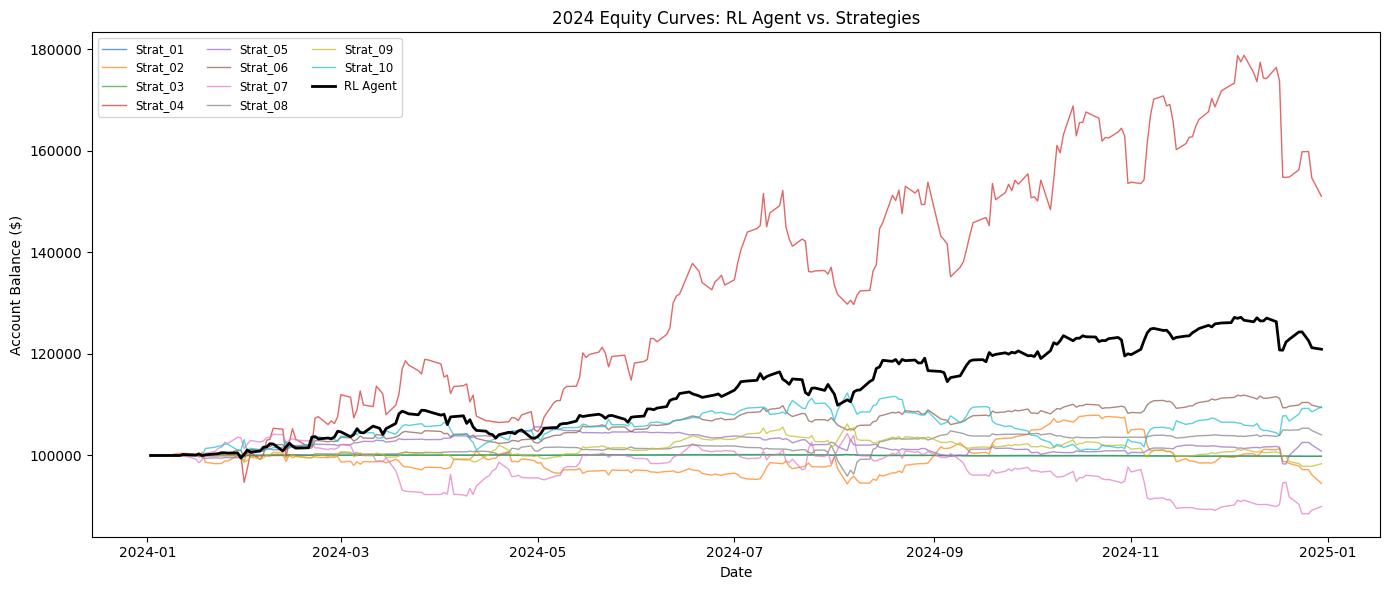

   Model  Final Balance  Ann. Sharpe  Max Drawdown
Strat_04    151018.1637       1.4012        0.1554
RL Agent    120924.2765       1.6430        0.0564
Strat_10    109581.3333       0.8058        0.1003
Strat_06    109434.0897       1.3561        0.0439
Strat_08    104050.8367       0.6618        0.0606
Strat_05    100853.2906       0.1686        0.0695
Strat_01     99861.3362      -0.4749        0.0038
Strat_03     99838.6219      -0.8669        0.0032
Strat_09     98380.1624      -0.1790        0.0786
Strat_02     94484.8356      -0.4269        0.1245
Strat_07     89969.7064      -0.5585        0.1515


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 7) EVALUATION ON TEST: RL + Baselines
# ══════════════════════════════════════════════════════════════════════════════
# simulate RL
env_test = AllocEnv(df_test,
                    turnover_penalty=best['turn'],
                    lambda_vol=best['lam'],
                    mu_dd=best['mu'],
                    final_bonus=1e-4, vol_window=10)
obs,_ = env_test.reset()
rl_eq = [env_test.balance]
rl_weights = []
done=False
while not done:
    action,_ = model.predict(obs, deterministic=True)
    obs,_,done,_,_ = env_test.step(action)
    rl_eq.append(env_test.balance)
    # record last_w
    rl_weights.append(env_test.last_w.copy())

# simulate each pure‐strategy
rets = df_test.Close.pct_change().fillna(0).values
def simulate(signals, returns, init=1e5):
    bal=init
    out=[bal]
    for sig,r in zip(signals,returns):
        bal += bal*sig*r
        out.append(bal)
    return np.array(out)

strat_eqs = {}
for i,f in enumerate(strategy_funcs, start=1):
    s = f(df_test).fillna(0).values
    strat_eqs[f"Strat_{i:02d}"] = simulate(s, rets)

# ══════════════════════════════════════════════════════════════════════════════
# 8) METRIC FUNCTIONS
# ══════════════════════════════════════════════════════════════════════════════
def sharpe(equity, periods_per_year=252):
    # daily returns of equity
    r = np.diff(equity)/equity[:-1]
    return np.mean(r)/ (np.std(r)+1e-8) * np.sqrt(periods_per_year)

def max_drawdown(equity):
    eq = np.array(equity)
    roll_max = np.maximum.accumulate(eq)
    dd = (roll_max - eq)/roll_max
    return float(dd.max())

# ══ 9) PLOT ALL EQUITY CURVES (fixed alignment) ═════════════════════════
# full dates
dates_full = df_test.index

# drop initial capital from RL and each strat
rl_curve_raw = np.array(rl_eq[1:])
strat_curves_raw = {name: eq[1:] for name, eq in strat_eqs.items()}

# find minimum length
lengths = [len(dates_full), len(rl_curve_raw)] + [len(c) for c in strat_curves_raw.values()]
min_len = min(lengths)

# truncate all to min_len
dates      = dates_full[:min_len]
rl_curve   = rl_curve_raw[:min_len]
strat_curves = {name: c[:min_len] for name, c in strat_curves_raw.items()}

# Sanity check: all series lengths must match
assert all(len(curve) == len(dates) for curve in strat_curves.values())
assert len(rl_curve) == len(dates)

# ─── PLOT EQUITY CURVES ───────────────────────────────────────────────────────
plt.figure(figsize=(14,6))
for name, curve in strat_curves.items():
    plt.plot(dates, curve, alpha=0.7, linewidth=1, label=name)
plt.plot(dates, rl_curve, 'k-', linewidth=2, label='RL Agent')
plt.legend(ncol=3, fontsize='small', loc='upper left')
plt.title("2024 Equity Curves: RL Agent vs. Strategies")
plt.xlabel("Date"); plt.ylabel("Account Balance ($)")
plt.tight_layout()
plt.show()

# ─── PERFORMANCE TABLE ────────────────────────────────────────────────────────
rows = []
rows.append({
    'Model': 'RL Agent',
    'Final Balance': float(rl_curve[-1]),
    'Ann. Sharpe': sharpe(rl_curve),
    'Max Drawdown': max_drawdown(rl_curve)
})
for name, curve in strat_curves.items():
    rows.append({
        'Model': name,
        'Final Balance': float(curve[-1]),
        'Ann. Sharpe': sharpe(curve),
        'Max Drawdown': max_drawdown(curve)
    })

perf_df = pd.DataFrame(rows).sort_values('Final Balance', ascending=False)
print(perf_df.to_string(index=False, float_format="%.4f"))
